**Description**: Temporarily open pretrained EC and check why its TPR/TNR isn't what I expected. Probably because threshold wasn't taken properly.

In [1]:
from importlib import reload
import gnn_tracking_hpo
reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path, find_checkpoint

add_scripts_path()

In [2]:
from tune_fixed_ec import PretrainedECTrainable

In [3]:
PretrainedECTrainable._device = "cpu"

In [4]:
project = "fixed-ec-b7b3f0d4"
hash = "1503094f"

In [5]:
from gnn_tracking_hpo.util.paths import get_config

config = get_config(project, hash)
config["n_graphs_train"] = 1
config["n_graphs_val"] = 100
config["n_graphs_test"] = 1
config["m_mask_orphan_nodes"] = True
config["ec_epoch"] = -1
# config["m_ec_threshold"] = 0.0

[18:34:38 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-b7b3f0d4/PretrainedECTrainable_1503094f_6_attr_pt_thld=0.7040,batch_size=5,ec_hash=b7b3f0d4,ec_project=ec,ec_pt_thld=0.0000,gnn_tracking_ex_2023-01-26_12-57-40/params.json


In [6]:
trainable = PretrainedECTrainable(config)

trainable.load_checkpoint(find_checkpoint(project, hash, -1), device="cpu")

[18:34:38 gnnt_hpo] INFO: Initializing pre-trained EC
[18:34:38 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_b7b3f0d4_38_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=50f90c1_2023-01-24_03-06-50/params.json
[18:34:38 gnnt_hpo] INFO: I'm running on a node with job ID=45499833
[18:34:38 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[18:34:38 gnnt_hpo] INFO: The ID of my dispatcher is 0
[18:34:38 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[18:34:38 gnnt_hpo] DEBUG: Got config
{'batch_size': 5,
 'ec_loss': 'focal',
 'ec_pt_thld': 0.7710612479097784,
 'focal_alpha': 0.3824243521658318,
 'focal_gamma': 2.5581270116033084,
 'gnn_tracking_experiments_hash': '50f90c1b6d806c3bce012abda77e6310b3423f41',
 'gnn_tracking_hash': '525e92fe1359fbff371f73c405c37b6d6ec22b32',
 'lr': 0.00049290409721272

In [7]:
results = trainable.trainer.test_step()

[18:35:11 gnnt_hpo] WARNING: Running on a gnn_tracking version with post-EC node pruning.
[18:35:11 ClusterHP] INFO: Starting hyperparameter scan for clustering
[18:35:12 ClusterHP] INFO: Completed 1 trials, pruned 0 trials
[18:35:12 ClusterHP] DEBUG: Evaluating all metrics for best clustering
[18:35:14 ClusterHP] DEBUG: Clustering time: 0.217438, total metric eval: 1.631165, individual: v_measure: 0.11191219184547663, homogeneity: 0.10641915994347073, completeness: 0.10513155203079805, trk: 1.1660949428915046, adjusted_rand: 0.07546936490689404, fowlkes_mallows: 0.06613790889969096
[18:35:14 ClusterHP] INFO: Evaluating all metrics took 1.86 seconds
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encoun

In [8]:
trainable.trainer._log_losses(results)

[18:35:14 TCNTrainer] INFO: 
+-----+--------------------------------+-----------+------------------------+
|     | Metric                         |     Value | Error                  |
+=====+================================+===========+========================+
|     | F1_pt0.9                       |   0.86024 | 0.01361075903838009    |
|     | F1_pt1.5                       |   0.82187 | 0.034155116378419746   |
|     | FNR_pt0.9                      |   0.08745 | 0.01242530594426536    |
|     | FNR_pt1.5                      |   0.13116 | 0.03248621869989019    |
|     | FPR_pt0.9                      |   0.00353 | 0.0002561898038496652  |
|     | FPR_pt1.5                      |   0.00364 | 0.0004296238036445013  |
|     | MCC_pt0.9                      |   0.85923 | 0.01353776606333065    |
|     | MCC_pt1.5                      |   0.82040 | 0.03402695462321902    |
|     | TNR_pt0.9                      |   0.99647 | 0.000256189803849664   |
|     | TNR_pt1.5                  

In [39]:
import torch

trainer = trainable.trainer
trainer.model.eval()

stop = 20

cluster_input = []
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        mo = model_output
        cluster_input.append(
            dict(
                x=mo["x"].cpu().numpy(), truth=mo["particle_id"][mo["ec_hit_mask"]].cpu().numpy(), pts=mo["pt"][mo["ec_hit_mask"]].cpu().numpy(), reconstructable=mo["reconstructable"][mo["ec_hit_mask"]].cpu().numpy()
            )
        )
        if idx == stop:
            break

In [43]:
import numpy as np
eps = np.linspace(0.5, 1.1, 100)

In [58]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics
from gnn_tracking.postprocessing.dbscanscanner import dbscan
from tqdm import tqdm


def get(min_samples=1):
    dms = []
    dmstds = []
    for e in tqdm(eps):
        _dms = []
        for inpt in cluster_input:
            labels = dbscan(inpt["x"], eps=e, min_samples=min_samples)
            dm = tracking_metrics(truth=inpt["truth"], pts=inpt["pts"], reconstructable=inpt["reconstructable"], predicted=labels, pt_thlds=[0.9])
            _dms.append(dm[0.9]["double_majority"])
        dms.append(np.mean(_dms))
        dmstds.append(np.std(_dms) / np.sqrt(len(cluster_input)))
    return np.array(dms), np.array(dmstds)

In [53]:
dms2, dmstds2 = get(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


In [73]:
dms4, dmstds4 = get(4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


In [74]:
dms = np.array(dms)
dmstds = np.array(dmstds)

In [75]:
import matplotlib.pyplot as plt

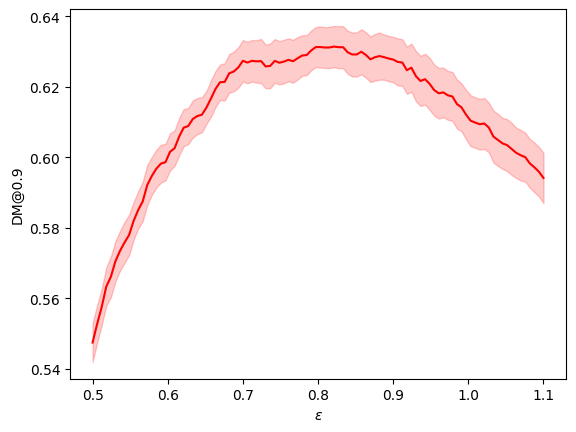

In [77]:
fig, ax = plt.subplots()
ax.set_ylabel("DM@0.9")
ax.set_xlabel(r"$\epsilon$")
ax.fill_between(eps, dms-dmstds, dms+dmstds, color="r", alpha=0.2)
ax.plot(eps, dms, c="r")
# ax.fill_between(eps, dms2-dmstds2, dms2+dmstds2, color="k", alpha=0.2)
# ax.plot(eps, dms2, c="k")
# ax.plot(eps, dms4, c="b")
# ax.plot(eps, dms5, c="k")
